# K-Nearest Neighbors Regressor (KNN)

In this notebook, I use the K-Nearest Neighbors (KNN) algorithm to predict house prices for the Kaggle Housing Prices competition. KNN is a straightforward, instance-based learning method that makes predictions based on the similarity between data points.

## How it works in this project:
For each house in the test set, the algorithm finds the 'k' most similar houses in the training set, based on their features (such as size, location, and number of rooms).
The predicted price is calculated as the average price of these 'k' nearest neighbors.
The value of 'k' is a key parameter and is chosen based on model performance.

## Why KNN?
KNN does not make strong assumptions about the underlying data distribution, making it flexible for various types of data.
It is easy to implement and interpret, providing a good baseline for regression tasks like house price prediction.
Important notes for this notebook:
Since KNN relies on distance calculations, all features are scaled to ensure fair comparison.
The model’s performance is evaluated using cross-validation to select the optimal value of 'k'.



# Data Preprocessing

In [37]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# training data:
train_raw = pd.read_csv('data/train.csv')
test_raw = pd.read_csv('data/test.csv')

# get features and targets:
X_train = train_raw.drop(['SalePrice', 'Id'], axis=1)  # drop id and saleprice from the x train data, id holds no actual value and cannot have saleprice in the x train
y_train = train_raw["SalePrice"]  # isolate target feature for y train
X_test = test_raw.copy()  # can just copy as test.csv doesn't have the target

# separate numerical and categorical features:
numFeatures = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
catFeatures = X_train.select_dtypes(include=['object']).columns.tolist()

# utilize pipelines for preprocessing:
numPipeline = Pipeline([('imputer', SimpleImputer(strategy='median')),
                        ('scaler', StandardScaler())])  # will impute and scale numerical data

catPipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')),
                        ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))])  # will impute and one-hot encode categorical data

# combine workflows:
preprocessor = ColumnTransformer([('numerical', numPipeline, numFeatures),
                                  ('categorical', catPipeline, catFeatures)])

# now, fit and transform data:

# use preprocessor to process train and test data:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# convert to pd dataframes:

# need to concatenate processed numerical and categorical features:
numFeature_names = numFeatures
catFeature_names = preprocessor.named_transformers_['categorical'].named_steps['onehot'].get_feature_names_out(catFeatures)

# concatenate
totalFeatures = np.concatenate((numFeature_names, catFeature_names))

# convert to dataframes:
X_train_processed = pd.DataFrame(X_train_processed, columns=totalFeatures)
X_test_processed = pd.DataFrame(X_test_processed, columns=totalFeatures)

print("Processed Train dataset: ", X_train_processed.shape)
print("Processed Test dataset: ", X_test_processed.shape)
print(X_train_processed.head())

# write out preprocessed data:
X_train_processed.to_csv('data/train_processed.csv', index=False)
X_test_processed.to_csv('data/test_processed.csv', index=False)

# ===================== run a spearman correlation coefficient to eliminate features with no correlation =====================

# add SalePrice back for correlation analysis
correlation_df = X_train_processed.copy()
correlation_df['SalePrice'] = y_train.values

# compute Spearman correlation matrix
spearman_corr = correlation_df.corr(method='spearman')

# extract correlation of all features to SalePrice and sort
spearman_target_corr = spearman_corr['SalePrice'].drop('SalePrice').sort_values(key=lambda x: abs(x), ascending=False)

# display top correlations
print("\nTop Spearman Correlations with SalePrice:\n")
print(spearman_target_corr)


# from this we'll drop features with less than 0.1 correlation (value can be tweaked for performance)
threshold = 0.075
strong_features = spearman_target_corr[abs(spearman_target_corr) >= threshold].index

# filter out features with correlation below threshold
X_train_filtered = X_train_processed[strong_features]
X_test_filtered = X_test_processed[strong_features]

X_train_filtered.to_csv('data/train_filtered.csv', index=False)
X_test_filtered.to_csv('data/test_filtered.csv', index=False)

Processed Train dataset:  (1460, 287)
Processed Test dataset:  (1459, 287)
   MSSubClass  LotFrontage   LotArea  OverallQual  OverallCond  YearBuilt  \
0    0.073375    -0.220875 -0.207142     0.651479    -0.517200   1.050994   
1   -0.872563     0.460320 -0.091886    -0.071836     2.179628   0.156734   
2    0.073375    -0.084636  0.073480     0.651479    -0.517200   0.984752   
3    0.309859    -0.447940 -0.096897     0.651479    -0.517200  -1.863632   
4    0.073375     0.641972  0.375148     1.374795    -0.517200   0.951632   

   YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  ...  SaleType_ConLw  \
0      0.878668    0.514104    0.575425   -0.288653  ...             0.0   
1     -0.429577   -0.570750    1.171992   -0.288653  ...             0.0   
2      0.830215    0.325915    0.092907   -0.288653  ...             0.0   
3     -0.720298   -0.570750   -0.499274   -0.288653  ...             0.0   
4      0.733308    1.366489    0.463568   -0.288653  ...             0.0   

   Sa

# Implementation of K Nearest Neighbors
Will use Euclidian and Manhattan distance, as well as weighted and unweighted KNN

In [9]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class KNN:
    def __init__(self, k, distance, weighted=False):
        self.k = k
        self.distance = distance
        self.weighted = weighted
        self.X_train = None
        self.y_train = None
        self.X_test = None
        self.pca = None
        
    # fit
    def fit(self, X, y, pca_components=None):
        # fit with PCA (if chosen):
        if pca_components is not None:
            self.pca = PCA(n_components=pca_components)
            self.X_train = self.pca.fit_transform(X)
            
        # normal fit:
        else:
            self.X_train = X if isinstance(X, list) else X
        self.y_train = y if isinstance(y, list) else y
        
        # convert to numpy arrays:
        self.X_train = np.array(self.X_train)
        self.y_train = np.array(self.y_train)
        
    # helper method to calculate distances:
    def calculateDistance(self, p1, p2):
        p1 = np.array(p1, dtype=float)
        p2 = np.array(p2, dtype=float)
        
        if self.distance.lower() == 'manhattan':
            return np.sum(np.abs(p1 - p2))
        
        elif self.distance.lower() == 'euclidean':
            return np.sqrt(np.sum((p1 - p2) ** 2))
        
        elif self.distance.lower() == 'chebyshev':
            return np.max(np.abs(p1 - p2))
        
        elif self.distance.lower() == 'minkowski':
            return np.sum(np.abs(p1 - p2) ** 1.5) ** (1/1.5)
        
        elif self.distance.lower() == 'mahalanobis':
            V = np.linalg.inv(np.cov(self.X_train.T))
            delta = p1 - p2
            return np.sqrt(np.dot(np.dot(delta, V), delta.T))
        
        elif self.distance.lower() == 'correlation':
            return 1 - np.corrcoef(p1, p2)[0, 1]
        
        else:
            raise ValueError(f"Unknown distance metric: {self.distance}")
         
    # predict
    def predict(self, X):
        if self.pca:
            X = self.pca.transform(X)
        else:
            X = X.values if isinstance(X, pd.DataFrame) else X
            
        predictions = []
        
        for x in X:
            # compute distance:
            distances = [self.calculateDistance(x, x_train) for x_train in self.X_train]
            
            # get knns
            knn_indices = np.argsort(distances)[:self.k]
            knn_distances = [distances[i] for i in knn_indices]
            knn_prices = [self.y_train[i] for i in knn_indices]
            
            # if weighted:
            if self.weighted:
                weights = 1 / np.array(knn_distances) + 1e-8  # avoid div by 0
                prediction = np.average(knn_prices, weights=weights)
            else:
                # calculate prediction using mean price of knns:
                prediction = np.mean(knn_prices)
            
            # append prediction:
            predictions.append(prediction)
            
        return np.array(predictions)
    
    # get accuracy metrics in format [RMSE, MAE, R2]:
    def measure_accuracy(self, X, y):
        y_pred = self.predict(X)
        RMSE = np.sqrt(mean_squared_error(y, y_pred))
        MAE = mean_absolute_error(y, y_pred)
        R2 = r2_score(y, y_pred)
        return [RMSE, MAE, R2]


## Application of Model:

Utilize an 80/20 test-train split on training data and calculate error to find best configuration for optimal KNN model.

k = 2, pca = 2, weighted: True  |  RMSE = 36905.95 | MAE = 25960.34 | R2 = 0.82
k = 2, pca = 2, weighted: False  |  RMSE = 36700.30 | MAE = 25966.11 | R2 = 0.82
k = 2, pca = 3, weighted: True  |  RMSE = 33147.64 | MAE = 22741.01 | R2 = 0.86
k = 2, pca = 3, weighted: False  |  RMSE = 33274.90 | MAE = 22627.54 | R2 = 0.86
k = 2, pca = 5, weighted: True  |  RMSE = 29568.16 | MAE = 20205.32 | R2 = 0.89
k = 2, pca = 5, weighted: False  |  RMSE = 29144.06 | MAE = 20021.60 | R2 = 0.89
k = 2, pca = 10, weighted: True  |  RMSE = 31880.86 | MAE = 21159.40 | R2 = 0.87
k = 2, pca = 10, weighted: False  |  RMSE = 32313.61 | MAE = 21529.61 | R2 = 0.86
k = 2, pca = 15, weighted: True  |  RMSE = 33833.10 | MAE = 20967.31 | R2 = 0.85
k = 2, pca = 15, weighted: False  |  RMSE = 34606.90 | MAE = 21280.26 | R2 = 0.84
k = 2, pca = 25, weighted: True  |  RMSE = 32970.97 | MAE = 19494.98 | R2 = 0.86
k = 2, pca = 25, weighted: False  |  RMSE = 33594.98 | MAE = 19439.14 | R2 = 0.85
k = 2, pca = 30, weighted: T

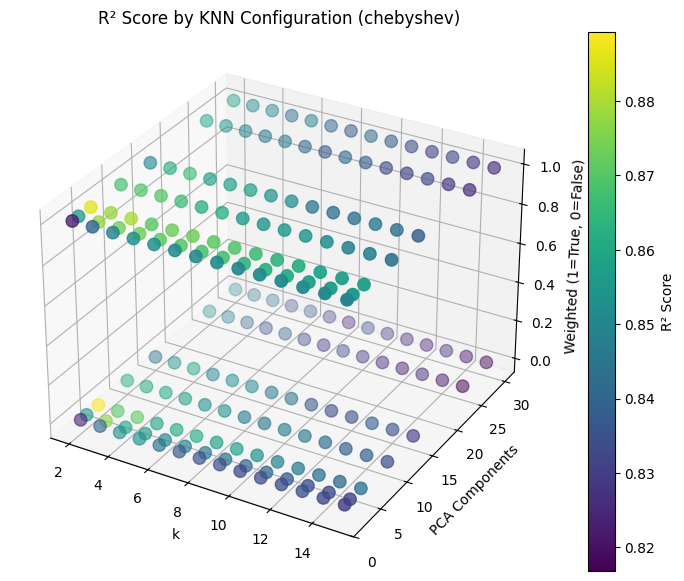

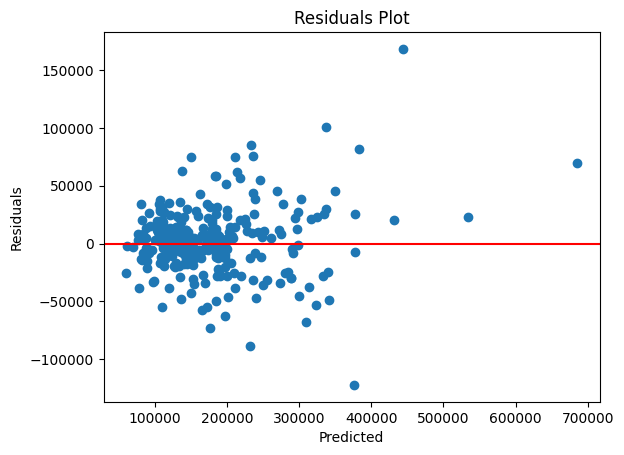

Filename: data/chebyshev_prediction_2025-05-31_17-16-28.csv
Complete.


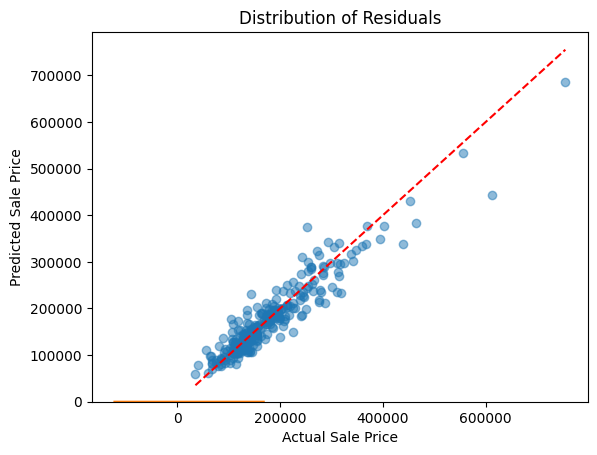

In [48]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# load data: 
X = pd.read_csv('data/train_filtered.csv')
y = pd.read_csv('data/train.csv')['SalePrice']
competition_test = pd.read_csv('data/test_filtered.csv')
raw_competition_test = pd.read_csv('data/test.csv')  # don't use processed file for the Id's

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

bestRMSE_stats = [None, None, None, None]  # format: RMSE, k, pca, weighted?

# set model config:

distanceMetric = 'chebyshev'

featuresTest = True

# find the best choice of k:
if featuresTest:

    results = []
    
    for k in [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]:
        for pca in [2, 3, 5, 10, 15, 25, 30]:
            for weighted in [True, False]:
                knn = KNN(k=k, distance=distanceMetric, weighted=weighted)
                knn.fit(X_train, y_train, pca_components=pca)
                [RMSE, MAE, R2] = knn.measure_accuracy(X_test, y_test)
                print(f'k = {k}, pca = {pca}, weighted: {weighted}  |  RMSE = {RMSE:.2f} | MAE = {MAE:.2f} | R2 = {R2:.2f}')
                
                results.append({
                    'k': k,
                    'pca': pca,
                    'weighted': weighted,
                    'RMSE': RMSE,
                    'MAE': MAE,
                    'R2': R2
                })
                
                if bestRMSE_stats[0] is None:
                    bestRMSE_stats = [RMSE, MAE, R2, k, pca, weighted]
                elif bestRMSE_stats[0] > RMSE:
                    bestRMSE_stats = [RMSE, MAE, R2, k, pca, weighted]
    
    print(f'Best Configuration: k: {bestRMSE_stats[3]} | pca: {bestRMSE_stats[4]} | weighted: {bestRMSE_stats[5]} | RMSE: {bestRMSE_stats[0]:.2f} | MAE: {bestRMSE_stats[1]:.2f} | R2: {bestRMSE_stats[2]:.2f}')
    
    # Prepare data
    ks = [r['k'] for r in results]
    pcas = [r['pca'] for r in results]
    weighteds = [1 if r['weighted'] else 0 for r in results]  # convert bool to int for color
    R2s = [r['R2'] for r in results]
    
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(ks, pcas, weighteds, c=R2s, cmap='viridis', s=80)
    
    ax.set_xlabel('k')
    ax.set_ylabel('PCA Components')
    ax.set_zlabel('Weighted (1=True, 0=False)')
    plt.title(f'R² Score by KNN Configuration ({distanceMetric})')
    
    cbar = plt.colorbar(sc)
    cbar.set_label('R² Score')
    
    plt.show()

# make prediction of test data using optimal model:

# download best performing model's predictions:
model = KNN(k=bestRMSE_stats[3], distance=distanceMetric, weighted=bestRMSE_stats[5])
model.fit(X_train, y_train, pca_components=bestRMSE_stats[4])
model_pred = model.predict(competition_test)

residuals = y_test - model.predict(X_test)
plt.scatter(model.predict(X_test), residuals)
plt.axhline(0, color='red')
plt.title('Residuals Plot')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.show()

plt.scatter(y_test, model.predict(X_test), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Prices")

sns.histplot(residuals, kde=True)
plt.title("Distribution of Residuals")

# write out:
from datetime import datetime

now = datetime.now()
modelDF = pd.DataFrame({'Id': raw_competition_test['Id'],
                            'SalePrice': model_pred})
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

filename = f"data/{distanceMetric}_prediction_{timestamp}.csv"
print("Filename:", filename)

modelDF.to_csv(filename, index=False)
print("Complete.")